Methodology:

This same mechanism can be applied to other, non language, types of sequence.

Here we consider three types of sequence: 1) sequences of arbitrary symbols as in Durrant et al. (2011), in order to model the improved ability to  2) sequences of transitions in a graph as in Whittington et al. (2020), 3) sequences of text - as causal language modelling was originally intended for - in order to explore distortions of memory for narratives increasing over time (as in Bartlett et al.) 

We create a set of graphs, each one an n by n grid of nodes representing a simple spatial environment. Nodes are labelled with random letters to represent associations at a particular location (as in Whittington et al.). Each directed edge, i.e. each possible transition in the graph, is of the type north, south, east, or west.

Random walks in the graph are used to train the model. These represent sequences stored in an initial bank of memories. The generative model is trained on the replayed sequences with the mechanism of causal language modelling, as used to train GPT-2.

Causal language modelling

GPT-2 learns an explicit density model in which each sequence has a probability, 

Perplexity is defined as the exponential of the average negative log-likelihood of a sequence, where the average is taken across all tokens. In other words, for each token the log-likelihood of that token given the preceding tokens is found, then these values are averaged. Taking the negative then the exponential of this value gives a positive number that indicates how 'surprising' a sequence is to the model's learned probability distribution.

These results show that the original proposal can be extended to sequences, and that one way to do so is the use of autoregressive neural networks, twhich learn to predict the next item in a sequence. Whilst intended for language, these can be adapted for many other types of sequence.

We suggest that this could explain the following observations:
* 
*
*



In [ ]:
!pip install simpletransformers

In [ ]:
!pip install csrgraph

In [1]:
import pandas as pd
import networkx as nx

In [2]:
def get_graph(nodes = ["a", "b", "c", "d", "e", "f", "g", "h", "i"]):

    G = nx.DiGraph()
    east_pairs = [(nodes[0], nodes[1]), (nodes[1], nodes[2]), (nodes[3], nodes[4]), 
                  (nodes[4], nodes[5]), (nodes[6], nodes[7]), (nodes[7], nodes[8])]
    south_pairs = [(nodes[0], nodes[3]), (nodes[3], nodes[6]), (nodes[1], nodes[4]), 
                   (nodes[4], nodes[7]), (nodes[2], nodes[5]), (nodes[5], nodes[8])]
    north_pairs = [(i[1], i[0]) for i in south_pairs]
    west_pairs = [(i[1], i[0]) for i in east_pairs]

    for n in nodes:
        G.add_node(n)

    for tple in east_pairs:
        G.add_edge(tple[0], tple[1], direction='E')
    for tple in north_pairs:
        G.add_edge(tple[0], tple[1], direction='N')
    for tple in west_pairs:
        G.add_edge(tple[0], tple[1], direction='W')
    for tple in south_pairs:
        G.add_edge(tple[0], tple[1], direction='S')

    return G


In [3]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_G(G):
    pos = nx.spring_layout(G, iterations=100, seed=39775)

    fig, ax = plt.subplots(1)

    nx.draw(G, pos, ax=ax, font_size=8, with_labels=True)

    fig.tight_layout()
    plt.show()

#plot_G(G)

In [4]:
import csrgraph as cg
import numpy as np
import random
import string

def get_random_walks(G):
    csr_G = cg.csrgraph(G, threads=12) 
    node_names = csr_G.names
    walks = csr_G.random_walks(walklen=50, # length of the walks
                    epochs=10, 
                    start_nodes=None, 
                    return_weight=1.,
                    neighbor_weight=1.)

    walks = np.vectorize(lambda x: node_names[x])(walks)
    return walks

In [5]:
def walk_to_string(walk, G):
    walk_string = ""
    for i in range(len(walk)-1):
        node1 = walk[i]
        node2 = walk[i+1]
        direc = G.edges[(node1, node2)]['direction']
        walk_string += str(node1) + " "+ str(direc) + " "
    walk_string += walk[-1]
    return walk_string

def get_walks_as_strings():
    entities_for_graphs =[[random.choice(string.ascii_letters[0:26]) for i in range(9)] for i in range(1000)]
    entities_for_graphs = [entities for entities in entities_for_graphs if len(list(set(entities)))== 9]

    walks_as_strings = []
    for nodes in entities_for_graphs:
        G = get_graph(nodes=nodes)
        walks = get_random_walks(G)
        walks_as_strings.extend([walk_to_string(walk, G) for walk in walks])
    return walks_as_strings

walks_as_strings = get_walks_as_strings()

In [6]:
import logging
from random import shuffle

from simpletransformers.language_modeling import (
    LanguageModelingModel,
    LanguageModelingArgs,
)


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

model_args = LanguageModelingArgs()
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True
model_args.num_train_epochs = 10
model_args.dataset_type = "simple"
model_args.save_model_every_epoch = False
model_args.evaluate_during_training = True
model_args.mlm = False  # mlm must be False for CLM
model_args.learning_rate = 1e-6
model_args.vocab_size=100
model_args.use_early_stopping = True

text_file = open("train.txt", "w")
walks = get_walks_as_strings()[0:10000]
shuffle(walks)
n = text_file.write('\n'.join(walks))
text_file.close()

text_file = open("test.txt", "w")
walks = get_walks_as_strings()[0:1000]
shuffle(walks)
n = text_file.write('\n'.join(walks))
text_file.close()

train_file = "train.txt"
test_file = "test.txt"

model = LanguageModelingModel(
    "gpt2", None, train_files='train.txt', args=model_args
)

# Train the model
model.train_model(train_file, eval_file=test_file)

# Evaluate the model
result = model.eval_model(test_file)

INFO:simpletransformers.language_modeling.language_modeling_model: Training of None tokenizer complete. Saved to outputs/.
file outputs/config.json not found
INFO:simpletransformers.language_modeling.language_modeling_model: Training language model from scratch
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/15634 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_train.txt
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
INFO:simpletransformers.language_modeling.language_modeling_model: Training started


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/1955 [00:00<?, ?it/s]

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Running Epoch 1 of 10:   0%|          | 0/1955 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt
INFO:simpletransformers.language_modeling.language_modeling_model: No improvement in eval_loss
INFO:simpletransformers.language_modeling.language_modeling_model: Current step: 1
INFO:simpletransformers.language_modeling.language_modeling_model: Early stopping patience: 3
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt


Running Epoch 2 of 10:   0%|          | 0/1955 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt


Running Epoch 3 of 10:   0%|          | 0/1955 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt
INFO:simpletransformers.language_modeling.language_modeling_model: No improvement in eval_loss
INFO:simpletransformers.language_modeling.language_modeling_model: Current step: 1
INFO:simpletransformers.language_modeling.language_modeling_model: Early stopping patience: 3
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt


Running Epoch 4 of 10:   0%|          | 0/1955 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt


Running Epoch 5 of 10:   0%|          | 0/1955 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt
INFO:simpletransformers.language_modeling.language_modeling_model: No improvement in eval_loss
INFO:simpletransformers.language_modeling.language_modeling_model: Current step: 1
INFO:simpletransformers.language_modeling.language_modeling_model: Early stopping patience: 3
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt


Running Epoch 6 of 10:   0%|          | 0/1955 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt


Running Epoch 7 of 10:   0%|          | 0/1955 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt
INFO:simpletransformers.language_modeling.language_modeling_model: No improvement in eval_loss
INFO:simpletransformers.language_modeling.language_modeling_model: Current step: 1
INFO:simpletransformers.language_modeling.language_modeling_model: Early stopping patience: 3
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt


Running Epoch 8 of 10:   0%|          | 0/1955 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt
INFO:simpletransformers.language_modeling.language_modeling_model: No improvement in eval_loss
INFO:simpletransformers.language_modeling.language_modeling_model: Current step: 1
INFO:simpletransformers.language_modeling.language_modeling_model: Early stopping patience: 3
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt


Running Epoch 9 of 10:   0%|          | 0/1955 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt
INFO:simpletransformers.language_modeling.language_modeling_model: No improvement in eval_loss
INFO:simpletransformers.language_modeling.language_modeling_model: Current step: 2
INFO:simpletransformers.language_modeling.language_modeling_model: Early stopping patience: 3
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt
INFO:simpletransformers.language_modeling.language_modeling_model: Training of gpt2 model complete. Saved to outputs/.
INFO:simpletransformers.language_modeling.language_modeling_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_utils: Saving features into cached file cache_dir/gpt2_cached_lm_126_test.txt


Running Evaluation:   0%|          | 0/196 [00:00<?, ?it/s]

INFO:simpletransformers.language_modeling.language_modeling_model:{'eval_loss': 1.0938143693670934, 'perplexity': tensor(2.9856)}


In [26]:
from simpletransformers.language_generation import LanguageGenerationModel, LanguageGenerationArgs

model = LanguageGenerationModel("gpt2", "outputs", args={'do_sample': False, 'evaluate_generated_text': True})
#model = LanguageGenerationModel("gpt2", "outputs", args={'num_beams': 100, 'num_return_sequences': 5, 'do_sample': True})


In [27]:
model.generate("a E b S e W d N")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
INFO:simpletransformers.language_generation.language_generation_model:=== GENERATED SEQUENCE 1 ===
INFO:simpletransformers.language_generation.language_generation_model:a E b S e W d N e S e N e S e E e W


['a E b S e W d N e S e N e S e E e W']

In [9]:
prompts = ["c E f W", "u N h S", "v W o E", "j S h N"]
for prompt in prompts:
    print(prompt)
    print(model.generate(prompt)[0][0:len(prompt)+2])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


c E f W


INFO:simpletransformers.language_generation.language_generation_model:=== GENERATED SEQUENCE 1 ===
INFO:simpletransformers.language_generation.language_generation_model:c E f W c E c W c E c W c E
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


c E f W c
u N h S


INFO:simpletransformers.language_generation.language_generation_model:=== GENERATED SEQUENCE 1 ===
INFO:simpletransformers.language_generation.language_generation_model:u N h S h N h S h N h S h N
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


u N h S h
v W o E


INFO:simpletransformers.language_generation.language_generation_model:=== GENERATED SEQUENCE 1 ===
INFO:simpletransformers.language_generation.language_generation_model:v W o E v W o E v W o E v W
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


v W o E v
j S h N


INFO:simpletransformers.language_generation.language_generation_model:=== GENERATED SEQUENCE 1 ===
INFO:simpletransformers.language_generation.language_generation_model:j S h N j E j W j E j W j E


j S h N j


In [12]:
model.generate("b E c N f S")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
INFO:simpletransformers.language_generation.language_generation_model:=== GENERATED SEQUENCE 1 ===
INFO:simpletransformers.language_generation.language_generation_model:b E c N f S c N c S c N c S c N


['b E c N f S c N c S c N c S c N']

In [ ]:
model.generate("c E f W")

In [13]:
model.generate("n N q E p S m W")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
INFO:simpletransformers.language_generation.language_generation_model:=== GENERATED SEQUENCE 1 ===
INFO:simpletransformers.language_generation.language_generation_model:n N q E p S m W n N n S n N n E n W


['n N q E p S m W n N n S n N n E n W']

In [14]:
model.generate("n E p S m W v N")

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
INFO:simpletransformers.language_generation.language_generation_model:=== GENERATED SEQUENCE 1 ===
INFO:simpletransformers.language_generation.language_generation_model:n E p S m W v N v E v W v E v W v E


['n E p S m W v N v E v W v E v W v E']

<Figure size 432x288 with 0 Axes>

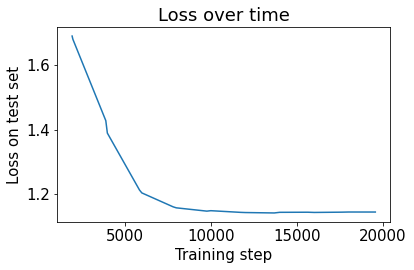

In [91]:
import pandas as pd
from matplotlib import pyplot as plt

plt.figure()
plt.rcParams.update({'font.size' : 15})

#df = pd.read_csv('outputs_best_so_far/training_progress_scores.csv')
#df.at[0,'eval_loss'] = 1.91
#df.at[0,'eval_loss'] = 1.51
df.plot(x='global_step', y='eval_loss', title='Loss over time', 
                   ylabel='Loss on test set', xlabel = 'Training step', legend=False)

plt.tight_layout()
plt.savefig('graph-gpt.png')

In [83]:
df.at[0,'eval_loss'] = 1.69
df.at[1,'eval_loss'] = 1.68

In [84]:
df

,global_step,perplexity,eval_loss,train_loss
0,1955,tensor(4.9275),1.690000,1.580271
1,2000,tensor(4.8995),1.680000,1.548511
2,3910,tensor(4.1714),1.428263,1.286327
3,4000,tensor(4.0140),1.389796,1.332442
4,5865,tensor(3.3660),1.213714,1.248935
5,6000,tensor(3.3360),1.204765,1.155488
6,7820,tensor(3.1950),1.161574,1.150539
7,8000,tensor(3.1854),1.158575,1.116949
8,9775,tensor(3.1529),1.148327,1.065105
9,10000,tensor(3.1574),1.149734,1.092129
